In [1]:
import sys
# sys.path.insert(0,'C:/Users/annal/OneDrive/Documents/python3.8/pygplates_rev28_python38_win64')
# sys.path.insert(0,'/Users/omer/Documents/pygplates_rev18_python27_MacOS64')
sys.path.insert(0,'/Users/omer/Documents/pygplates_rev28_python38_MacOS64/')
sys.path.insert(1,'/Applications/GMT-6.0.0.app/Contents/Resources')
import pandas as pd

In [2]:
# !pip install scipy

In [3]:
# !pip install healpy 
# !pip instadll statsmodels

In [4]:
import pygplates
import numpy as np
import os
import math
import sphere_tools as sph
import matplotlib.pyplot as plt
import itertools
from scipy import stats
import statsmodels
import sys
from matplotlib.lines import Line2D
from call_system_command import call_system_command
%matplotlib inline

In [5]:
def find_number_of_LIPs(age,window,point_features):
    
    agemax = age+window
    agemin = age-window
    
    count = 0
    
    for p in point_features:
        
        # NB valid_time is a tuple, we take the first value since this is the 'birth' time of the LIP
        BirthTime = p.get_valid_time()[0] 
        
        if BirthTime <= agemax and BirthTime > agemin:
            
            count+=1
    
    return count

In [6]:
def get_volcanic_product_long_lat(rotations,anchor_plate_id,age,window,point_features):
    
    agemax = age+window
    agemin = age-window
    
    Xr = []
    Yr = []

    for p in point_features:
        
        # NB valid_time is a tuple, we take the first value since this is the 'birth' time of the Kimberlite
        BirthTime = p.get_valid_time()[0] 
        
        if BirthTime <= agemax and BirthTime > agemin:
            
            PlateID = p.get_reconstruction_plate_id()

            # Get rotation for the point and reconstruct to its birth time if it's in age interval (window)
            Kimb_rotation = rotations.get_rotation(age, PlateID, anchor_plate_id)

            reconstructed_point = Kimb_rotation * p.get_geometry()
            reconstructed_point_degrees = reconstructed_point.to_lat_lon_point()

            Xr.append(reconstructed_point_degrees.get_longitude())
            Yr.append(reconstructed_point_degrees.get_latitude())
    
    
    return Xr, Yr

In [7]:
# generic function to sample grids using grdtrack and read results
def sample_using_gmt(grdfile, point_lons, point_lats,OutputDirectory):

        dataout = np.vstack((np.asarray(point_lons),np.asarray(point_lats))).T

        np.savetxt(OutputDirectory+'/tmp.txt',dataout)
        
        # Note -nn forces nearest neighbour interpolation
        call_system_command(['gmt',
                             'grdtrack',
                             '%s/tmp.txt' %OutputDirectory,
                             '-G{:s}'.format(grdfile), 
                             '-fg',
                             '-nn',
                             '-V',
                             '>', 
                             '%s/tmp_interp.txt' % OutputDirectory])
        G=[]
        with open(OutputDirectory+'/tmp_interp.txt') as f:
            for line in f:
                if line[0] == '>':
                    continue
                else:
                    tmp = line.split()
                    G.append(float(tmp[2]))

        f.close()
        return np.array(G)

In [8]:

def create_hot_nc_file(GridDirect,OutputDirect,FlowModelName,Age):
    Age=int(Age)
    XYZFile="%s/%s_%dMa.xyz" %(GridDirect,FlowModelName,Age)
    print(XYZFile)

    TempGrid1="%s/%s_TempGrid1_%d_Ma.nc" %(OutputDirect,FlowModelName,Age)
    TempGrid2="%s/%s_TempGrid2_%d_Ma.nc" %(OutputDirect,FlowModelName,Age)
    GridOutput1_0="%s/%s_1Hot_0Cold_%d_Ma.nc" %(OutputDirect,FlowModelName,Age)
    hot_xyz_file="%s/%s_hot_%d_Ma.xyz" %(OutputDirect,FlowModelName,Age)
    
    DistanceFROMHot="%s/%s_%d_Ma_Distance_to_Hot.nc" %(OutputDirect,FlowModelName,Age)
    
#     gmt blockmedian $filexyz -Rd -I0.1 -V > $medianfile
#     gmt surface $medianfile -I0.1 -R${region} -V -G$gridFile # Resolution is 0.1 deg.
#     gmt grdclip $gridFile -Rd -G$gridFile_1_0 -Sa0.99/1 -Sb0.99/0 -V # Set values equal and above 1 as 1, others as 0.
    
    call_system_command(['gmt',
                         'blockmedian',
                          XYZFile,
                          '-Rd',
                          '-I1',
                          '-V',
                          '>',
                          '%s' % TempGrid1])

    call_system_command(['gmt',
                         'surface',
                          TempGrid1,
                          '-Rd',
                          '-I1',
                          '-G%s'%TempGrid2])   

    
    call_system_command(['gmt',
                         'grdclip',
                         TempGrid2,
                         '-Rd',
                         '-G%s' % GridOutput1_0,
                         '-Sa0.99/1',
                         '-Sb0.99/0',
                         '-V'])    

    call_system_command(['gmt',
                         'grd2xyz',
                         GridOutput1_0,
                         '-Rd',
                         '-di0',  # set all cells with '0' to be nodata
                         '-s',
                         '>',
                         '%s' % hot_xyz_file])

    call_system_command(['gmt',
                         'grdmath',
                         GridOutput1_0,
                         '%s' % hot_xyz_file,
                         'PDIST',
                         'KM2DEG',
                         '=',
                         '%s' % DistanceFROMHot])

In [9]:
GridDirect="/Users/omer/Desktop/NatGeoReviews/Flow-Models/Case1/"
OutputDirect="/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Flow-Model-Stats/Case1/WholeMantle/"
FlowModel="Case1_WholeMantle"

# # "%s%s.nc" %(GridDirect,FlowModel)
# for Age in np.arange(200,20,-20):

# # FlowModel="Case1_WholeMantle_180Ma"
#     create_hot_nc_file(GridDirect,OutputDirect,FlowModel,Age)

In [10]:
# DistanceFROMHot

In [11]:
def run_random_sampling(nPoints,age,dist_to_hot_nc_file,CalcOutputDir):
    
    age=int(age)
    recon_label = 'M21-NNR'
    ReconstructionDir='/Users/omer/Desktop/NatGeoReviews/Reconstruction_Models/M21NNR/'
    cratonFile=ReconstructionDir+"shapes_cratons_Merdith_et_al.gpml"
    cratons = pygplates.FeatureCollection(cratonFile)    

    input_rotation_filename1 = '%s/1000-410_rotations-NNR.rot' % ReconstructionDir
    input_rotation_filename2 = '%s/Global_EB_410-250Ma_GK07_2017-NNR.rot' % ReconstructionDir
    input_rotation_filename3 = '%s/Global_EB_250-0Ma_GK07_2017-NNR.rot' % ReconstructionDir
    input_rotation_filename4 = '%s/NR_0Ma_1000Ma_for_gplates.rot' % ReconstructionDir
    rotation_model = pygplates.RotationModel([input_rotation_filename1,input_rotation_filename2,\
                                              input_rotation_filename3,input_rotation_filename4])

    ANCHOR_ID = int(0)
        
    randomLons = []
    randomLats = []
    random_pdist2hot = []
   
    
    # Start with an empty list of features
    features_to_modify = []
    new_features=[]
    reconstructed_feature_geometries=[]
    
    # Reconstruct cratonic shapes at Age Ma
    pygplates.reconstruct(cratons, rotation_model, reconstructed_feature_geometries, age)
    
#     print(reconstructed_feature_geometries)
#     print(age)
    
    RandomPoints_Lats=np.array([])
    RandomPoints_Lons=np.array([])
    
    totalRandomInsideCratons=0
    
    while(totalRandomInsideCratons<nPoints):
        random_point = sph.random_points_feature(1)
        for mp in random_point:
            for point in mp.get_geometry().get_points():
                pointInDegrees=point.to_lat_lon_point()
                PointLat=pointInDegrees.get_latitude()
                PointLon=pointInDegrees.get_longitude()
                
#                 for static_polygon in cratons:
                for static_polygon in reconstructed_feature_geometries:
#                     PlateID = static_polygon.get_reconstruction_plate_id()
#                     static_polygon_geom = static_polygon.get_geometry()
                    static_polygon_geom = static_polygon.get_reconstructed_geometry()
                    if static_polygon_geom != None:
                        if static_polygon_geom.is_point_in_polygon((PointLat,PointLon)):        
#                             print("inside")
                            RandomPoints_Lats=np.append(RandomPoints_Lats,PointLat)
                            RandomPoints_Lons=np.append(RandomPoints_Lons,PointLon)
                            totalRandomInsideCratons=totalRandomInsideCratons+1
                            cF=pygplates.Feature()
                            cF.set_geometry(point)
                            new_features.append(cF)
    output_feature_collection = pygplates.FeatureCollection(new_features)
    output_feature_collection.write("Random_"+str(nPoints)+"_Points_onCratons_ForCase1_"+str(age)+"_Ma_200Ma_fixed.gpml")

    # for the point locations of interest, sample the distance grids
    # (and the original cluster boolean grid as a sanity check)
    random_pdist2hot = sample_using_gmt(dist_to_hot_nc_file, RandomPoints_Lons, RandomPoints_Lats,CalcOutputDir)
#     random_cluster_bool = sample_using_gmt(cluster_nc_file, RandomPoints_Lons, RandomPoints_Lats)
    
    return random_pdist2hot

In [12]:
# reconstructed_feature_geometries=[]
# pygplates.reconstruct(cratons, rotation_model, reconstructed_feature_geometries, age)

In [13]:
# reconstructed_feature_geometries

200 Ma
0.10649417576052632 is the mean of the sample
94.73684210526316 % of the points are on Hot Structures
19
Random 1 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 11 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 21 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 31 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 41 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 51 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 61 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 71 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 81 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 91 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 101 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 111 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 121 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 131 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 141 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 151 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 161 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 171 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 181 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 191 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 201 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 211 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 221 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 231 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 241 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 251 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 261 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 271 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 281 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 291 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 301 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 311 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 321 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 331 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 341 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 351 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 361 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 371 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 381 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 391 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 401 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 411 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 421 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 431 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 441 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 451 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 461 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 471 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 481 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 491 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 501 out of 1000
MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 511 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 521 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 531 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 541 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 551 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 561 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 571 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 581 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 591 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 601 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 611 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 621 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 631 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

MUTATION!
Random 641 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 651 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 661 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 671 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 681 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 691 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 701 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 711 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 721 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 731 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 741 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 751 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 761 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 771 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 781 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 791 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 801 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 811 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 821 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 831 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 841 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 851 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 861 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 871 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 881 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 891 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 901 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 911 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 921 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 931 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 941 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 951 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 961 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 971 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 981 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 991 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

1.0 1.0  are ADFS_conf and ADFS_conf_0_25
n=19
180 Ma
0.4077451579711176 is the mean of the sample
79.41176470588235 % of the points are on Hot Structures
34
Random 1 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 11 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 21 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 31 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 41 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 51 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 61 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 71 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 81 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 91 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 101 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 111 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 121 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 131 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 141 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 151 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 161 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 171 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 181 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 191 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 201 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 211 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 221 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 231 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 241 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 251 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 261 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 271 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 281 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 291 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 301 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 311 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 321 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 331 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 341 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 351 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 361 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 371 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 381 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

MUTATION!
Random 391 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 401 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 411 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 421 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 431 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 441 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 451 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 461 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 471 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 481 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 491 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 501 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 511 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 521 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 531 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 541 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 551 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 561 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 571 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 581 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 591 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 601 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 611 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 621 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 631 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

MUTATION!
Random 641 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 651 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 661 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 671 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 681 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 691 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 701 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 711 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 721 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 731 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 741 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 751 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 761 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 771 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 781 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 791 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 801 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 811 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 821 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 831 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 841 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 851 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 861 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 871 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 881 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 891 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 901 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 911 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 921 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 931 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 941 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 951 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 961 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 971 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 981 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 991 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

1.0 1.0  are ADFS_conf and ADFS_conf_0_25
n>30
160 Ma
1.1205141344179252 is the mean of the sample
49.25373134328358 % of the points are on Hot Structures
67
Random 1 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 11 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 21 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 31 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 41 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>

Random 51 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 61 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 71 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 81 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 91 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 101 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 111 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 121 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 131 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 141 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 151 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 161 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 171 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 181 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 191 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 201 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 211 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 221 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 231 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 241 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 251 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 261 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 271 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 281 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 291 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 301 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 311 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 321 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 331 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 341 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 351 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 361 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 371 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 381 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 391 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 401 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 411 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 421 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 431 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 441 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 451 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 461 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 471 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 481 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 491 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 501 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 511 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 521 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 531 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 541 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 551 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 561 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 571 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 581 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 591 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 601 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 611 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 621 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 631 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 641 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 651 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 661 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 671 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 681 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 691 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 701 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 711 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 721 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 731 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 741 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 751 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 761 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 771 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 781 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 791 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 801 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 811 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 821 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 831 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 841 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 851 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 861 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 871 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 881 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 891 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 901 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 911 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 921 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 931 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 941 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 951 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 961 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!
Random 971 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 981 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 991 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

0.995 0.999  are ADFS_conf and ADFS_conf_0_25
n>30
140 Ma
3.347507767926768 is the mean of the sample
16.842105263157894 % of the points are on Hot Structures
95
Random 1 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 11 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 21 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 31 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 41 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 51 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 61 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 71 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 81 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 91 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 101 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 111 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 121 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 131 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 141 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 151 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 161 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 171 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 181 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 191 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 201 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 211 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 221 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 231 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 241 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 251 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 261 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 271 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 281 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 291 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 301 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 311 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 321 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 331 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 341 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 351 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 361 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 371 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 381 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 391 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 401 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 411 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 421 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 431 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 441 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 451 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 461 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 471 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 481 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 491 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 501 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 511 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 521 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 531 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 541 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 551 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 561 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 571 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 581 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 591 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 601 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 611 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 621 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 631 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 641 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 651 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 661 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 671 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 681 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 691 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 701 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 711 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 721 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 731 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 741 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 751 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 761 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 771 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 781 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 791 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 801 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 811 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 821 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 831 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 841 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 851 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 861 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 871 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 881 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 891 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 901 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 911 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 921 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 931 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 941 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 951 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 961 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 971 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 981 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 991 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

1.0 1.0  are ADFS_conf and ADFS_conf_0_25
n>30
120 Ma
2.8446294466660453 is the mean of the sample
37.878787878787875 % of the points are on Hot Structures
66
Random 1 out of 1000
Random 11 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 21 out of 1000
Random 31 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 41 out of 1000
Random 51 out of 1000
Random 61 out of 1000
Random 71 out of 1000
Random 81 out of 1000
Random 91 out of 1000
Random 101 out of 1000
Random 111 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 121 out of 1000
Random 131 out of 1000
Random 141 out of 1000
Random 151 out of 1000
Random 161 out of 1000
Random 171 out of 1000
Random 181 out of 1000
Random 191 out of 1000
Random 201 out of 1000
Random 211 out of 1000
Random 221 out of 1000
Random 231 out of 1000
Random 241 out of 1000
Random 251 out of 1000
Random 261 out of 1000
MUTATION!
Random 271 out of 1000
Random 281 out of 1000
Random 291 out of 1000
Random 301 out of 1000
Random 311 out of 1000
Random 321 out of 1000
Random 331 out of 1000
Random 341 out of 1000
Random 351 out of 1000
Random 361 out of 1000
Random 371 out of 1000
Random 381 out of 1000
Random 391 out of 1000
Random 401 out of 1000
MUTATION!
Random 411 out of 1000
Random 421 out of 1000
Random 431 out of 1000
Random 441 out of 1000
Random 451 out of 1000
Random 461 out of 1000
Random 471 out of 1000
Random 481 out of 1000
Random 491 out of 1000
Random 501 out of 1000
Random 511 out of 1000
Random 521 out of 1000
Random 531 out of 1000
Random 541 out

<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 571 out of 1000
MUTATION!
Random 581 out of 1000
Random 591 out of 1000
Random 601 out of 1000
Random 611 out of 1000
Random 621 out of 1000
Random 631 out of 1000
Random 641 out of 1000
Random 651 out of 1000
Random 661 out of 1000
Random 671 out of 1000
Random 681 out of 1000
Random 691 out of 1000
Random 701 out of 1000
Random 711 out of 1000
Random 721 out of 1000
Random 731 out of 1000
Random 741 out of 1000
Random 751 out of 1000
Random 761 out of 1000
MUTATION!
Random 771 out of 1000
Random 781 out of 1000
Random 791 out of 1000
Random 801 out of 1000
Random 811 out of 1000
Random 821 out of 1000
Random 831 out of 1000
Random 841 out of 1000
Random 851 out of 1000
Random 861 out of 1000
MUTATION!
Random 871 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 881 out of 1000
Random 891 out of 1000
Random 901 out of 1000
Random 911 out of 1000
MUTATION!
Random 921 out of 1000
Random 931 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 941 out of 1000
MUTATION!
Random 951 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 961 out of 1000
Random 971 out of 1000
Random 981 out of 1000
Random 991 out of 1000
0.782 1.0  are ADFS_conf and ADFS_conf_0_25
n>30
100 Ma
1.2010268543735931 is the mean of the sample
56.779661016949156 % of the points are on Hot Structures
118
Random 1 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 11 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 21 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 31 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 41 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 51 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 61 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 71 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 81 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 91 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 101 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 111 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 121 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 131 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 141 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 151 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 161 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 171 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 181 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 191 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 201 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 211 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 221 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 231 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 241 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 251 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 261 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 271 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 281 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 291 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 301 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 311 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 321 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 331 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 341 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 351 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 361 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 371 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 381 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 391 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 401 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 411 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 421 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 431 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 441 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 451 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 461 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 471 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 481 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 491 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 501 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 511 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 521 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 531 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 541 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 551 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 561 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 571 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 581 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 591 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 601 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 611 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 621 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 631 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 641 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 651 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 661 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 671 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 681 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 691 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 701 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 711 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 721 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 731 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 741 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 751 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 761 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 771 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 781 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 791 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 801 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 811 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 821 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

MUTATION!
Random 831 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 841 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 851 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 861 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 871 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 881 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 891 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 901 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 911 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 921 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 931 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 941 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 951 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 961 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 971 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 981 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 991 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

1.0 1.0  are ADFS_conf and ADFS_conf_0_25
n>30
80 Ma
1.79307856776537 is the mean of the sample
59.39393939393939 % of the points are on Hot Structures
165
Random 1 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 11 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 21 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 31 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 41 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 51 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 61 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 71 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 81 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 91 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 101 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 111 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 121 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 131 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 141 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

MUTATION!
Random 151 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

MUTATION!
Random 161 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 171 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 181 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 191 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 201 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 211 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 221 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 231 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 241 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 251 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 261 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 271 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 281 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 291 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 301 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 311 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 321 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 331 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 341 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 351 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 361 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 371 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 381 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 391 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 401 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 411 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 421 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 431 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 441 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 451 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 461 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 471 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 481 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 491 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 501 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 511 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 521 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 531 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

MUTATION!
Random 541 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 551 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 561 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 571 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 581 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 591 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 601 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 611 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 621 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 631 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 641 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 651 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 661 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 671 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 681 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 691 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 701 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 711 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 721 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 731 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 741 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 751 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 761 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 771 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 781 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 791 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 801 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 811 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 821 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 831 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 841 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 851 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 861 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 871 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 881 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 891 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 901 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 911 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 921 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 931 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 941 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 951 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 961 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 971 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 981 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 991 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

1.0 1.0  are ADFS_conf and ADFS_conf_0_25
n>30
60 Ma
1.247226064982093 is the mean of the sample
44.18604651162791 % of the points are on Hot Structures
86
Random 1 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 11 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 21 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 31 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 41 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 51 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 61 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 71 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 81 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 91 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 101 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 111 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 121 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 131 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 141 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 151 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 161 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 171 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 181 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 191 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 201 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 211 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 221 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 231 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 241 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 251 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 261 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 271 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 281 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 291 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 301 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 311 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 321 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 331 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 341 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 351 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 361 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 371 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 381 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 391 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 401 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 411 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 421 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 431 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 441 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 451 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 461 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 471 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 481 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 491 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 501 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 511 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 521 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 531 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 541 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 551 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 561 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 571 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 581 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 591 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 601 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 611 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 621 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 631 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 641 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 651 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 661 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 671 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 681 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 691 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 701 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 711 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 721 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 731 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 741 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 751 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 761 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 771 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 781 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 791 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 801 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 811 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 821 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 831 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 841 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 851 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 861 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 871 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 881 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 891 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 901 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 911 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 921 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 931 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 941 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 951 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 961 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 971 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 981 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64d

Random 991 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


0.981 1.0  are ADFS_conf and ADFS_conf_0_25
n>30
40 Ma
1.311937302351 is the mean of the sample
41.666666666666664 % of the points are on Hot Structures
12
Random 1 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 11 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 21 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 31 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarni

Random 41 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 51 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 61 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 71 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 81 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 91 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 101 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 111 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 121 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 131 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 141 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 151 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 161 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 171 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 181 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 191 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 201 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 211 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarni

Random 221 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 231 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 241 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 251 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 261 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 271 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 281 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 291 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 301 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 311 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 321 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 331 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 341 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 351 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarni

Random 361 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 371 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 381 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 391 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 401 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarni

Random 411 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarni

Random 421 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 431 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarni

Random 441 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 451 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 461 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 471 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 481 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 491 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 501 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarni

Random 511 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 521 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 531 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 541 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 551 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 561 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarni

Random 571 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 581 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 591 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 601 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 611 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 621 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 631 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 641 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 651 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 661 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 671 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 681 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 691 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 701 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 711 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarni

Random 721 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 731 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarni

Random 741 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 751 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 761 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 771 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 781 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 791 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 801 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 811 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 821 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 831 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 841 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 851 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 861 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 871 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarni

Random 881 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 891 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 901 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 911 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 921 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 931 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 941 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 951 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 961 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 971 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 981 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 991 out of 1000


<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
<ipython-input-14-1b2580d64dfb>:164: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


0.195 0.514  are ADFS_conf and ADFS_conf_0_25
n=12


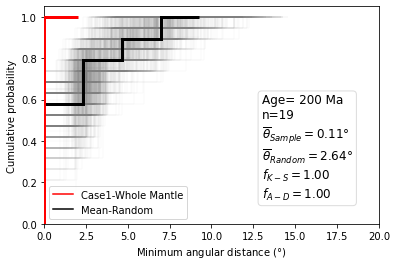

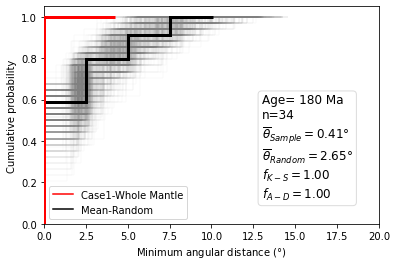

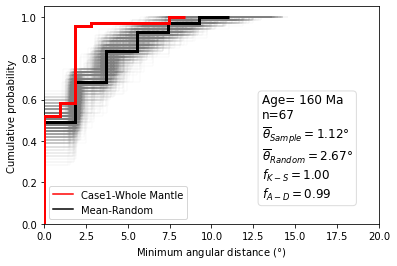

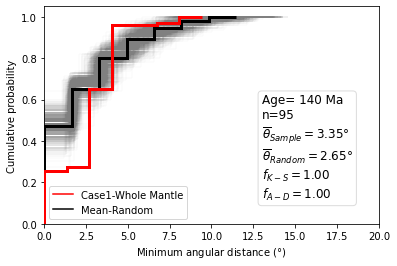

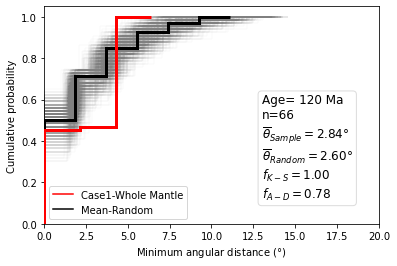

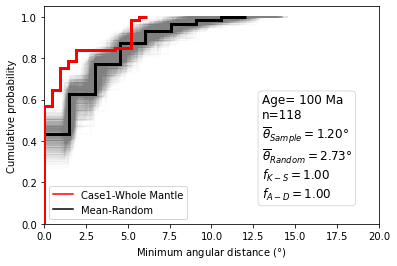

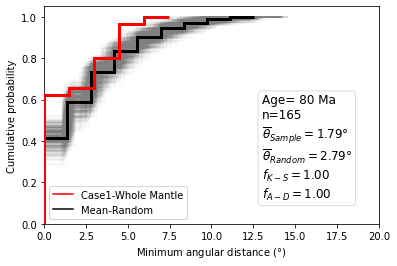

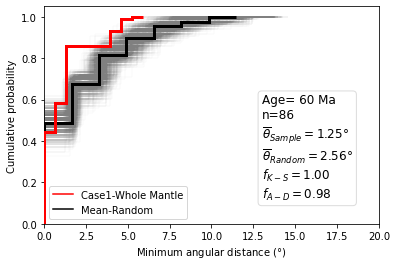

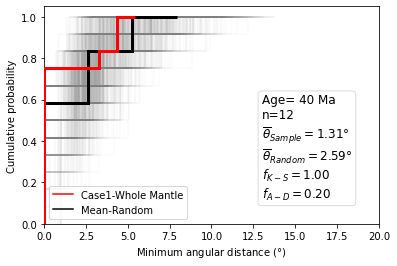

In [14]:
# root_dir = '/Users/omer/Documents/Programming/PyGplates/Supplement/Latest/'
# grid_dir = '/Users/omer/Documents/Programming/PyGplates/Supplement/Latest/'
# solid_plot_dir = '/Users/omer/Documents/Programming/PyGplates/Supplement/Latest/solid'
KimberlitesFile='/Users/omer/Desktop/NatGeoReviews/Kimberlites/Tappe-et-al-2018-EPSL-Kimberlite_emplacement_ages-automatic-part1-with-locations-with-plate-IDs.gpml'
pc = pygplates.FeatureCollection(KimberlitesFile)
window = 10
# Tmin = int(160)
# Tmax = int(320)
# Tmax = int(180)

CalcOutputDir="/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Flow-Model-Stats/Case1/WholeMantle/"
grid_dir="/Users/omer/Desktop/NatGeoReviews/Flow-Models/Case1/"
OutputDirect="/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Flow-Model-Stats/Case1/WholeMantle/"
FlowModelN="Case1_WholeMantle"


# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)   

recon_label = 'M21-NNR'
ReconstructionDir='/Users/omer/Desktop/NatGeoReviews/Reconstruction_Models/M21NNR/'
cratonFile=ReconstructionDir+"shapes_cratons_Merdith_et_al.gpml"
cratons = pygplates.FeatureCollection(cratonFile)    

input_rotation_filename1 = '%s/1000-410_rotations-NNR.rot' % ReconstructionDir
input_rotation_filename2 = '%s/Global_EB_410-250Ma_GK07_2017-NNR.rot' % ReconstructionDir
input_rotation_filename3 = '%s/Global_EB_250-0Ma_GK07_2017-NNR.rot' % ReconstructionDir
input_rotation_filename4 = '%s/NR_0Ma_1000Ma_for_gplates.rot' % ReconstructionDir
rotation_model = pygplates.RotationModel([input_rotation_filename1,input_rotation_filename2,\
                                          input_rotation_filename3,input_rotation_filename4])




# fig2, ax2 = plt.subplots()
nTests=1000

for Age in np.arange(200,20,-20):
    fig, ax = plt.subplots()
    age = int(Age)
    print(Age, 'Ma')
    agemax = age+window
    agemin = age-window

    point_lats = []
    point_lons = []
    
    MIN_DISTANCE_HOT_DEG=[]
    MIN_SOLID_DISTANCE_DEG = []
    MIN_DISTANCE_HOT_DEG = []
    MIN_DISTANCE_HOT_DEG_STD = []

#     DistancetoHot="%s/%s_%d_Ma_Distance_to_Hot.nc" %(CalcOutputDir,FlowModelN,Age)
    AgeRHA=200
    DistancetoHot="%s/%s_%d_Ma_Distance_to_Hot.nc" %(CalcOutputDir,FlowModelN,AgeRHA)


    ANCHOR_ID=int(0)    
    point_lons, point_lats = get_volcanic_product_long_lat(rotation_model,ANCHOR_ID,age,window,pc)

    pdist2hot = sample_using_gmt(DistancetoHot, point_lons, point_lats,CalcOutputDir)
    
    if len(pdist2hot) > 0:

#         CUMULATIVE_MIN_DISTANCE_HOT_DEG.extend(pdist2hot)
        MIN_DISTANCE_HOT_DEG=pdist2hot
        MIN_DISTANCE_HOT_DEG_STD=np.std(pdist2hot)
        
#     print(CUMULATIVE_MIN_DISTANCE_HOT_DEG_STD)
    
    MEAN_MIN_SOLID_DISTANCE_DEG = []
    
    MEDIAN_MIN_SOLID_DISTANCE_DEG = []

    MEAN_MIN_SOLID_DISTANCE_DEG = np.mean(np.array(MIN_DISTANCE_HOT_DEG),axis=0)
    print(MEAN_MIN_SOLID_DISTANCE_DEG,'is the mean of the sample')
    
    # Calculate how many points are on Hot Structures -->
    k=np.asarray(MIN_DISTANCE_HOT_DEG)
    k=np.where(k<0.01,0.0,k)
    # np.where(np.asarray(CUMULATIVE_MIN_SOLID_DISTANCE_DEG) < 0.5)
    NumberOfPointsOnCold=np.count_nonzero(np.asarray(k))
    FractionOfPointsOnHotSOLIDCASE=100.0*(float(len(MIN_DISTANCE_HOT_DEG))-NumberOfPointsOnCold)/float(len(MIN_DISTANCE_HOT_DEG))
    print(FractionOfPointsOnHotSOLIDCASE,'% of the points are on Hot Structures')
    # --->
    
    MEDIAN_MIN_SOLID_DISTANCE_DEG = np.median(np.array(MIN_DISTANCE_HOT_DEG),axis=0)
    CalcOutputDir="/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Flow-Model-Stats/Case1/WholeMantle/"


    #work out the random test
    ALL_MIN_RANDOM_SOLID_DISTANCE_DEG = []

    MEAN_MIN_RANDOM_SOLID_DISTANCE_DEG = []
    
    STD_MIN_RANDOM_SOLID_DISTANCE_DEG = []
    
    ALL_MIN_RANDOM_SOLID_DISTANCE_DEG_SORTED =[]
    
    ANDERSON_DARLING_STAT_ALL_RANDOM_SAMPLES_SOLID = []
    ANDERSON_DARLING_CONFIDENCE_ALL_RANDOM_SAMPLES_SOLID = []
    ANDERSON_DARLING_FIVE_PERCENT_ALL_RANDOM_SAMPLES_SOLID = []
    
    MEDIANS_ALL_RANDOM_SAMPLES_SOLID = []
    
    MEANS_ALL_RANDOM_SAMPLES_SOLID = []
    FRACTION_ANDERSON_DARLING_ALL_MODELS_SOLID_conf=[]
    FRACTION_ANDERSON_DARLING_ALL_MODELS_SOLID_5pc=[]
    FRACTION_SMALLER_MEDIANS_ALL_MODELS_SOLID=[]
    FRACTION_SMALLER_MEANS_ALL_MODELS_SOLID=[]
    FRACTION_MEDIANS_AD_ALL_MODELS_SOLID=[]
    FRACTION_MEANS_AD_ALL_MODELS_SOLID=[]
    MEAN_MEDIANS_ALL_MODELS_SOLID=[]
    MEDIAN_ALL_MODELS_SOLID=[]
    MEDIAN_RANDOM_TEST_ALL_MODELS_SOLID=[]
    CumulativeRand=[]

    numKimbs=int(len(MIN_DISTANCE_HOT_DEG))
    print(numKimbs)
    KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_stat_two_sided=[]
    KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_pval_two_sided=[]
    
    FRACTION_KOLMOGOROV_ALL_MODELS_SOLID_stat_two_sided=[]
    FRACTION_KOLMOGOROV_ALL_MODELS_SOLID_pval_two_sided=[]
    for m in range(nTests):
        
        if m % 10 == 0:
            print('Random', m+1, 'out of', nTests)
        
        MIN_RANDOM_DISTANCE_TO_HOT = []
        MIN_RANDOM_DISTANCE_TO_HOT_DEG = []
        MIN_RANDOM_SOLID_DISTANCE_DEG = []
    
        
        random_pdist2hot = run_random_sampling(numKimbs,Age,DistancetoHot,CalcOutputDir)
        
        if len(random_pdist2hot) > 0:

            MIN_RANDOM_DISTANCE_TO_HOT.extend(random_pdist2hot)

        MIN_RANDOM_SOLID_DISTANCE_DEG = MIN_RANDOM_DISTANCE_TO_HOT
        
        
        if(len(MIN_DISTANCE_HOT_DEG)==len(random_pdist2hot)):
            ALL_MIN_RANDOM_SOLID_DISTANCE_DEG.append(MIN_RANDOM_DISTANCE_TO_HOT)        
        else:
            print('MUTATION!')
#             random_pdist2hot = run_random_sampling(numKimbs,Age,DistancetoHot,CalcOutputDir)
    
            ALL_MIN_RANDOM_SOLID_DISTANCE_DEG=ALL_MIN_RANDOM_SOLID_DISTANCE_DEG

        MEANS_ALL_RANDOM_SAMPLES_SOLID.append(np.mean(np.array(MIN_RANDOM_SOLID_DISTANCE_DEG),axis=0))
       
        MEDIANS_ALL_RANDOM_SAMPLES_SOLID.append(np.median(np.array(MIN_RANDOM_SOLID_DISTANCE_DEG),axis=0))
 
        #plot the cumulative histogram
        n, bins, patches = ax.hist(MIN_RANDOM_SOLID_DISTANCE_DEG, bins='fd', density=True, histtype='step',
                                cumulative=True, color='grey', linewidth=0.2, zorder=1,alpha=0.20)

        patches[0].set_xy(patches[0].get_xy()[:-1])
        
        
       
        AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG, 
                                                 MIN_RANDOM_SOLID_DISTANCE_DEG])
        
        
        ANDERSON_DARLING_STAT_ALL_RANDOM_SAMPLES_SOLID.append(AD1S)
        ANDERSON_DARLING_CONFIDENCE_ALL_RANDOM_SAMPLES_SOLID.append(AD3S)
#         print(AD3S, "... confidence level")
        ANDERSON_DARLING_FIVE_PERCENT_ALL_RANDOM_SAMPLES_SOLID.append(AD2S[2])
    
        KS1tS, KS2tS = stats.ks_2samp(MIN_DISTANCE_HOT_DEG, MIN_RANDOM_SOLID_DISTANCE_DEG,
                                      alternative='two-sided', mode='exact')

        KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_stat_two_sided.append(KS1tS)
        KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_pval_two_sided.append(KS2tS)
        
    #work out the fraction of random tests for which the null hypothesis cannot be rejected,
    #i.e. the sample distribution significantly differs from the random distribution
    ADFS_conf=float(sum(i < 0.05 for i in ANDERSON_DARLING_CONFIDENCE_ALL_RANDOM_SAMPLES_SOLID))/float(len(ANDERSON_DARLING_CONFIDENCE_ALL_RANDOM_SAMPLES_SOLID))
    
    ADFS_conf_0_25=float(sum(i < 0.25 for i in ANDERSON_DARLING_CONFIDENCE_ALL_RANDOM_SAMPLES_SOLID))/float(len(ANDERSON_DARLING_CONFIDENCE_ALL_RANDOM_SAMPLES_SOLID))
    print(ADFS_conf,ADFS_conf_0_25, " are ADFS_conf and ADFS_conf_0_25")

    count_ADS=0
    for k in range(len(ANDERSON_DARLING_STAT_ALL_RANDOM_SAMPLES_SOLID)):
        if ANDERSON_DARLING_STAT_ALL_RANDOM_SAMPLES_SOLID[k]>ANDERSON_DARLING_FIVE_PERCENT_ALL_RANDOM_SAMPLES_SOLID[k]:
            count_ADS+=1
    
    ADFS_5pc=float(float(count_ADS)/float(len(ANDERSON_DARLING_FIVE_PERCENT_ALL_RANDOM_SAMPLES_SOLID)))
        

    FRACTION_ANDERSON_DARLING_ALL_MODELS_SOLID_conf_25pc=[]
    
    FRACTION_ANDERSON_DARLING_ALL_MODELS_SOLID_conf.append(ADFS_conf)
    FRACTION_ANDERSON_DARLING_ALL_MODELS_SOLID_5pc.append(ADFS_5pc)
    FRACTION_ANDERSON_DARLING_ALL_MODELS_SOLID_conf_25pc.append(ADFS_conf_0_25)
    

    p=0.05
    
    n=int(len(MIN_DISTANCE_HOT_DEG))
    
    if(n==19):
        KScritNEW=0.1280
        print("n=19")
    elif(n==12):
        KScritNEW=0.1287
        print("n=12")
    else:
        KScritNEW=math.sqrt(-1.0*(math.log(1-p))/2.0) -(1.0/6.0)*n**(-1.0/2.0) +1/n
        print("n>30")
   
    KSFS_stat_two_sided=float(sum(i > KScritNEW for i in KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_stat_two_sided))/float(len(KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_stat_two_sided))

    KSFS_pval_two_sided=float(sum(i < 0.05 for i in KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_pval_two_sided))/float(len(KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_pval_two_sided))
    
    countSmean_KS=0
    for l in range(nTests):
        
        #find the number of successful tests for the solid case
#         if KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_stat_two_sided[l] < KScritNEW \
#         or KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_pval_two_sided[l] > 0.05:
#             countSmean_KS+=1
        
        if (KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_stat_two_sided[l] < KScritNEW):
            countSmean_KS+=1
        
    FRACTION_KS_Crit=float(1.0- countSmean_KS/nTests)
    
    countSmean_KS=0
    for l in range(nTests):
        
        if KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_stat_two_sided[l] < KScritNEW \
        or KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_pval_two_sided[l] > 0.05:
            countSmean_KS+=1
     
    FRACTION_KS_Crit_TwoCond=float(1.0- countSmean_KS/nTests)        
    
   #
#     ADFS_conf=float(sum(i < 0.05 for i in ANDERSON_DARLING_CONFIDENCE_ALL_RANDOM_SAMPLES_SOLID))/float(len(ANDERSON_DARLING_CONFIDENCE_ALL_RANDOM_SAMPLES_SOLID))
    
#     count_ADS=0
#     for k in range(len(ANDERSON_DARLING_STAT_ALL_RANDOM_SAMPLES_SOLID)):
#         if ANDERSON_DARLING_STAT_ALL_RANDOM_SAMPLES_SOLID[k]>ANDERSON_DARLING_FIVE_PERCENT_ALL_RANDOM_SAMPLES_SOLID[k]:
#             count_ADS+=1
    
#     ADFS_5pc=float(float(count_ADS)/float(len(ANDERSON_DARLING_FIVE_PERCENT_ALL_RANDOM_SAMPLES_SOLID)))
    
#     FRACTION_ANDERSON_DARLING_ALL_MODELS_SOLID_conf.append(ADFS_conf)
#     FRACTION_ANDERSON_DARLING_ALL_MODELS_SOLID_5pc.append(ADFS_5pc)
    
    
    #work out the fraction of random tests for which the median distance is greater than
    #in the sample distribution, i.e. sample points are closer to basal structures than
    #random points
    
    FRACTION_KOLMOGOROV_ALL_MODELS_SOLID_stat_two_sided.append(KSFS_stat_two_sided)
    
    
    FRACTION_KOLMOGOROV_ALL_MODELS_SOLID_pval_two_sided.append(KSFS_pval_two_sided)


    
    #work out the fraction of random tests for which the median distance is greater than
    #in the sample distribution, i.e. sample points are closer to basal structures than
    #random points
    
    FRACTION_SMALLER_MEDIANS_SOLID=float(sum(abs(i) > abs(MEDIAN_MIN_SOLID_DISTANCE_DEG) for i in MEDIANS_ALL_RANDOM_SAMPLES_SOLID))/float(len(MEDIANS_ALL_RANDOM_SAMPLES_SOLID))
   
    FRACTION_SMALLER_MEDIANS_ALL_MODELS_SOLID.append(FRACTION_SMALLER_MEDIANS_SOLID)
   
    FRACTION_SMALLER_MEANS_SOLID = float(sum(i > MEAN_MIN_SOLID_DISTANCE_DEG for i in MEANS_ALL_RANDOM_SAMPLES_SOLID))/float(len(MEANS_ALL_RANDOM_SAMPLES_SOLID))
   
    FRACTION_SMALLER_MEANS_ALL_MODELS_SOLID.append(FRACTION_SMALLER_MEANS_SOLID)
    
    
    countSmean=0 # 
#     countEmean=0
    countSmedian=0
    countSmeanWeak=0
#     countEmedian=0
    for l in range(nTests):
        if MEANS_ALL_RANDOM_SAMPLES_SOLID[l] >= MEAN_MIN_SOLID_DISTANCE_DEG \
        and ANDERSON_DARLING_STAT_ALL_RANDOM_SAMPLES_SOLID[l]>ANDERSON_DARLING_FIVE_PERCENT_ALL_RANDOM_SAMPLES_SOLID[l]:
            countSmean+=1
            
        if ANDERSON_DARLING_STAT_ALL_RANDOM_SAMPLES_SOLID[l]>ANDERSON_DARLING_FIVE_PERCENT_ALL_RANDOM_SAMPLES_SOLID[l]:
            countSmeanWeak+=1    
                
        if abs(MEDIANS_ALL_RANDOM_SAMPLES_SOLID[l]) >= abs(MEDIAN_MIN_SOLID_DISTANCE_DEG) \
        and ANDERSON_DARLING_STAT_ALL_RANDOM_SAMPLES_SOLID[l]>ANDERSON_DARLING_FIVE_PERCENT_ALL_RANDOM_SAMPLES_SOLID[l]:
            countSmedian+=1
            
    FRACTION_MEANS_AD_SOLID=float(float(countSmean)/float(nTests))
    FRACTION_MEANS_AD_SOLIDWeak=float(float(countSmeanWeak)/float(nTests))
    FRACTION_MEANS_AD_ALL_MODELS_SOLID.append(FRACTION_MEANS_AD_SOLID)

    FRACTION_MEDIANS_AD_SOLID=float(float(countSmedian)/float(nTests))
    FRACTION_MEDIANS_AD_ALL_MODELS_SOLID.append(FRACTION_MEDIANS_AD_SOLID)
    
#     print((100.0*float(countSmean)/nTests),' % of the time mean of the sample is less than random-Solid and Significantly Differs From Random')
    
    MEAN_MEDIANS_ALL_MODELS_SOLID.append(np.mean(np.array(MEDIANS_ALL_RANDOM_SAMPLES_SOLID),axis=0))
    
    #work out mean and median for the average of random samples for the solid case
    MEAN_MEAN_MIN_RANDOM_SOLID_DISTANCE_DEG = []
    MEDIAN_MEAN_MIN_RANDOM_SOLID_DISTANCE_DEG = []
    
    ALL_MIN_RANDOM_SOLID_DISTANCE_DEG_SORTED=np.sort(ALL_MIN_RANDOM_SOLID_DISTANCE_DEG, axis=-1,kind='stable')
    MEAN_MIN_RANDOM_SOLID_DISTANCE_DEG = np.mean(np.array(ALL_MIN_RANDOM_SOLID_DISTANCE_DEG_SORTED),axis=0)

#     below are the actual mim-max range
    MIN_MIN_RANDOM_SOLID_DISTANCE_DEG = np.amin(np.array(ALL_MIN_RANDOM_SOLID_DISTANCE_DEG_SORTED), axis=0)
    MAX_MIN_RANDOM_SOLID_DISTANCE_DEG = np.amax(np.array(ALL_MIN_RANDOM_SOLID_DISTANCE_DEG_SORTED), axis=0)
    
    MEAN_MEAN_MIN_RANDOM_SOLID_DISTANCE_DEG = np.mean(np.array(MEAN_MIN_RANDOM_SOLID_DISTANCE_DEG),axis=0)
    MEDIAN_MEAN_MIN_RANDOM_SOLID_DISTANCE_DEG = np.median(np.array(MEAN_MIN_RANDOM_SOLID_DISTANCE_DEG),axis=0)
            
    MEDIAN_ALL_MODELS_SOLID.append(MEDIAN_MIN_SOLID_DISTANCE_DEG)
    MEDIAN_RANDOM_TEST_ALL_MODELS_SOLID.append(MEDIAN_MEAN_MIN_RANDOM_SOLID_DISTANCE_DEG)
    
    
    
    
    
    # plot the cumulative histogram
    n6, bins6, patches6 = ax.hist(MEAN_MIN_RANDOM_SOLID_DISTANCE_DEG, bins='fd', density=True, histtype='step',
                            cumulative=True, label='Mean-Random', color='black', linewidth=3, zorder=4)
    
    patches6[0].set_xy(patches6[0].get_xy()[:-1])
    
    #plot the cumulative histogram
#     a=np.asarray(MIN_SOLID_DISTANCE_DEG)
    a=np.asarray(MIN_DISTANCE_HOT_DEG)
    a=a.round(4)
    
    n7, bins7, patches7 = ax.hist(a, bins='fd', density=True, histtype='step',
                            cumulative=True, label='Case1-Whole Mantle', color='red', linewidth=3, zorder=5)
        
    patches7[0].set_xy(patches7[0].get_xy()[:-1])
    
    # tidy up the figure

    #ax.grid(True)
#     ax.grid()
    ax.grid(zorder=0,linestyle='--', color='lightgrey')
#     ax.legend(loc='Whole right')
    ax.set_xlim(0,20)
    #ax.set_title('Cumulative step histograms')
    ax.set_xlabel('Minimum angular distance ($\degree$)')
    ax.set_ylabel('Cumulative probability')
#     ax.set_title('{:s} (Solid)'.format(model_case))

    textstr = '\n'.join((
        r'Age= %i Ma' %(Age,),
        r'n=%i' %(numKimbs,),
        r'$\overline{\theta}_{Sample}=%.2f\degree$' % (MEAN_MIN_SOLID_DISTANCE_DEG, ),
        r'$\overline{\theta}_{Random}=%.2f\degree$' %(np.mean(MEANS_ALL_RANDOM_SAMPLES_SOLID), ),
        r'$f_{K-S}=%.2f$' %(FRACTION_KS_Crit), # based on critical val.
        r'$f_{A-D}=%.2f$' %(ADFS_conf))) # 5 percent sig.


#         r'${\kappa}_{\bar{\theta}}=%.2f$' % (FRACTION_SMALLER_MEANS_SOLID, )))
    props = dict(boxstyle='round', facecolor='white', alpha=0.80,edgecolor='lightgrey')
    #ax.grid(True)
#     ax.grid(zorder=0,linestyle='--', color='lightgrey')
    # Create new legend handles but use the colors from the existing ones
    handles, labels = ax.get_legend_handles_labels()
    new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
    ax.legend(handles=new_handles[::-1], labels=labels[::-1], loc='lower left')
    ax.text(0.65, 0.10, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom', bbox=props)
 
    ax.grid(zorder=1,linestyle='--', color='lightgrey')
    
    fig.savefig('/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Flow-Model-Stats/Case1/WholeMantle/Case1-WholeMantle-'+str(Age)+'-Ma_for200MaRHA.pdf', 
                bbox_inches='tight', dpi=600)
    
#     plt.show()
    
    OutputDir="/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Flow-Model-Stats/Case1/Saved-Arrays"

    np.savetxt(OutputDir+'/Case1-WholeMantle-for200MaRHA-MIN-DISTANCES_'+str(Age)+'_Ma.txt',MIN_DISTANCE_HOT_DEG)

    np.save(OutputDir+'/Case1-WholeMantle-for200MaRHA-MIN-DISTANCES-STD_'+str(Age)+'_Ma.npy',MIN_DISTANCE_HOT_DEG_STD)

    np.save(OutputDir+'/Case1-WholeMantle-for200MaRHA-AD-Test-conf-5p-'+str(Age)+'_Ma.npy',ADFS_conf)

    np.save(OutputDir+'/Case1-WholeMantle-for200MaRHA-AD-Test-conf-25p-'+str(Age)+'_Ma.npy',ADFS_conf_0_25)

    np.save(OutputDir+'/Case1-WholeMantle-for200MaRHA-ks-stat-two-sided-'+str(Age)+'_Ma.npy',KSFS_stat_two_sided)
    
    np.save(OutputDir+'/Case1-WholeMantle-for200MaRHA-ks-stat-pval-'+str(Age)+'_Ma.npy',KSFS_pval_two_sided)
   
    np.save(OutputDir+'/Case1-WholeMantle-for200MaRHA-ks-stat-TwoCond-'+str(Age)+'_Ma.npy',FRACTION_KS_Crit_TwoCond)
    
    np.save(OutputDir+'/Case1-WholeMantle-for200MaRHA-KS-Stat-critical-val'+str(Age)+'_Ma.npy',FRACTION_KS_Crit)

#     for ind in np.arange(0.01,1,0.01):
#     a=float(sum(i < ind for i in ANDERSON_DARLING_CONFIDENCE_ALL_RANDOM_SAMPLES_SOLID))/ \
#     float(len(ANDERSON_DARLING_CONFIDENCE_ALL_RANDOM_SAMPLES_SOLID))
    
#     plt.scatter(ind,100.0*a,c='k',s=1)
#     plt.show()
    






In [15]:
# len(MIN_DISTANCE_HOT_DEG),len(random_pdist2hot)
#             ALL_MIN_RANDOM_SOLID_DISTANCE_DEG.append(MIN_RANDOM_DISTANCE_TO_HOT) 

In [16]:
# random_pdist2hot

In [17]:
# FRACTION_MEANS_AD_SOLID is the % that shorter distance and highly difference from random is achieved.

In [18]:
# FRACTION_MEANS_AD_SOLID,FRACTION_MEANS_AD_SOLIDWeak

In [19]:
# AD1S, AD2S, AD3S 

In [20]:
# AD3S

In [21]:
# for ind in np.arange(0.01,0.25,0.005):
#     a=float(sum(i < ind for i in ANDERSON_DARLING_CONFIDENCE_ALL_RANDOM_SAMPLES_SOLID))/ \
#     float(len(ANDERSON_DARLING_CONFIDENCE_ALL_RANDOM_SAMPLES_SOLID))
    
#     plt.scatter(ind,100.0*a,c='k',s=1)
# plt.show()

In [22]:
# float(sum(i < 0.05 for i in ANDERSON_DARLING_CONFIDENCE_ALL_RANDOM_SAMPLES_SOLID))/float(len(ANDERSON_DARLING_CONFIDENCE_ALL_RANDOM_SAMPLES_SOLID))
    